In [1]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# Load HAZMAT Crash data & Preprocessing

In [2]:
df = pd.read_csv("Incident Report All fields NJ.csv")
df.head()

,Report Number,Multiple Rows Per Incident,Carrier Reporter Name,Incident Route,Incident City,Incident State,Date Of Incident,Incident Time,Quantity Released,Unit Of Measure,...,Causes of Failure,Event Description,Serious Indicator,Serious Bulk Release,Serious Evacuations,Fatalities Indicator,Hazmat Injury Indicator,Major Artery Closed,Serious Radioactive,Incident Result
0,E-2009040119,No,SAFETY-KLEEN,NEW JERSEY TURNPIKE EXIT 10 NB,METUCHEN,NJ,2009-03-09,1606,6000.0,LGA,...,Rollover Accident,"WHILE TRANSPORTING LOAD, DRIVER LOSS CONTROL O...",No,Yes,No,No,No,Yes,No,Spillage
1,E-2009050081,No,Estes Express Lines,67 Green Pond Road,ROCKAWAY,NJ,2009-03-31,1940,4.0,LGA,...,Too Much Weight on Package,NaN,No,No,No,No,No,No,No,Spillage
2,E-2009060219,No,"Schneider National Bulk Carriers, Inc",155 Smith St.,KEASBEY,NJ,2009-05-21,450,0.5,LGA,...,Deterioration or Aging,The cargo tank was parked in the yard at our f...,No,No,No,No,No,No,No,Spillage
3,E-2009060238,No,Estes Express Lines,118 West Main Street,SOMERVILLE,NJ,2009-05-06,1130,1.0,LGA,...,"Impact with Sharp or Protruding Object (e.g., ...",The driver U/A to the consignee noticed the ca...,No,No,No,No,No,No,No,Spillage
4,E-2009070368,Yes,Estes Express Lines,67 Green Pond RD,ROCKAWAY,NJ,2009-06-22,700,5.0,LGA,...,NaN,The cans had heavy freight stacked on to p of ...,No,No,No,No,No,No,No,Spillage


In [3]:
df.insert(1, 'lon', np.nan)
df.insert(2, 'lat', np.nan)
df.insert(3, 'neighborhood', np.nan)
df.insert(4, 'rating', np.nan)

# Geocoding

In [4]:
conn = psycopg2.connect("dbname='geocoder' user='postgres' host='localhost' password='postgres'")
    
print("Database connected!")

cur = conn.cursor()

for i in df.index:
    address = df.loc[i, 'Incident Route']
    expression = """SELECT g.rating, ST_X(g.geomout), ST_Y(g.geomout), (addy).location FROM geocode('%s, NJ', 1) AS g;""" % address
    cur.execute(expression)
    
    try:
        rows = [str(x) for x in cur.fetchall()[0]]

        df.loc[i, 'lon'] = rows[1]
        df.loc[i, 'lat'] = rows[2]
        df.loc[i, 'neighborhood'] = rows[3]
        df.loc[i, 'rating'] = rows[0]
    
    except:
        pass
    
    print("%d/%d finished" % (i + 1, len(df)), end='\r')

conn.close()

Database connected!


# Results

In [5]:
df[df.loc[:, 'lon'].notna()].head()

,Report Number,lon,lat,neighborhood,rating,Multiple Rows Per Incident,Carrier Reporter Name,Incident Route,Incident City,Incident State,...,Causes of Failure,Event Description,Serious Indicator,Serious Bulk Release,Serious Evacuations,Fatalities Indicator,Hazmat Injury Indicator,Major Artery Closed,Serious Radioactive,Incident Result
0,E-2009040119,-74.1622556390478,40.7509598813359,East Newark,108,No,SAFETY-KLEEN,NEW JERSEY TURNPIKE EXIT 10 NB,METUCHEN,NJ,...,Rollover Accident,"WHILE TRANSPORTING LOAD, DRIVER LOSS CONTROL O...",No,Yes,No,No,No,Yes,No,Spillage
1,E-2009050081,-74.6031649432036,39.5977369810236,Egg Harbor City,50,No,Estes Express Lines,67 Green Pond Road,ROCKAWAY,NJ,...,Too Much Weight on Package,NaN,No,No,No,No,No,No,No,Spillage
2,E-2009060219,-73.9836631267646,40.8086174558758,Edgewater,17,No,"Schneider National Bulk Carriers, Inc",155 Smith St.,KEASBEY,NJ,...,Deterioration or Aging,The cargo tank was parked in the yard at our f...,No,No,No,No,No,No,No,Spillage
3,E-2009060238,-74.0244094024595,40.8765238346435,Bogota,11,No,Estes Express Lines,118 West Main Street,SOMERVILLE,NJ,...,"Impact with Sharp or Protruding Object (e.g., ...",The driver U/A to the consignee noticed the ca...,No,No,No,No,No,No,No,Spillage
4,E-2009070368,-74.6031649432036,39.5977369810236,Egg Harbor City,50,Yes,Estes Express Lines,67 Green Pond RD,ROCKAWAY,NJ,...,NaN,The cans had heavy freight stacked on to p of ...,No,No,No,No,No,No,No,Spillage


# Result Quality Evaluation

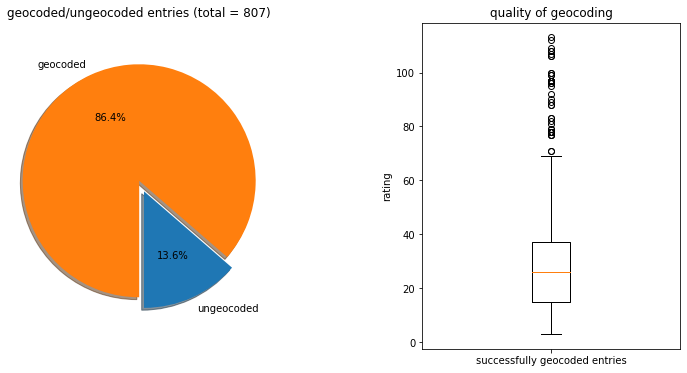

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

labels = 'ungeocoded', 'geocoded'
sizes = [len(df[df.loc[:, 'lon'].isna()]), len(df[df.loc[:, 'lon'].notna()])]
explode = (0.1, 0)

ax[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=-90)
ax[0].axis('equal')
ax[0].set_title('geocoded/ungeocoded entries (total = 807)')

ax[1].boxplot(df[df.loc[:, 'lon'].notna()]['rating'].astype(int))
ax[1].set(ylabel='rating', axisbelow=True, xticklabels=['successfully geocoded entries'])
ax[1].set_title('quality of geocoding')

plt.subplots_adjust(wspace = 0.6)

fig.savefig('HAZMAT_geocode.png', dpi=300, bbox_inches='tight')

plt.show()

# Export Data

In [7]:
df[df.loc[:, 'lon'].notna()].to_csv('HAZMAT_geocoded.csv', index=None)